In [1]:
import json
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

np.random.seed(123)
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

In [2]:
apartments = pd.read_csv('resources/data/apartments_train.csv')
buildings = pd.read_csv('resources/data/buildings_train.csv')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)

apartments_test = pd.read_csv('resources/data/apartments_test.csv')
buildings_test = pd.read_csv('resources/data/buildings_test.csv')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)



# Numerical Features
First, I look at the numerical features, before I treat the categorical ones. I do both a pairs plot to look for any interesting patterns, and calculate the covaraiance of each numerical feeature with the response.

In [76]:
df = data[ [column for column in data if column not in ['id']]]
df_num = df.select_dtypes(include = ['float64', 'int64'])
print("Features that are not numerical:")
for c in df.columns:
    if c not in df_num.columns:
        print(c)
df_num["price"] = np.log(df_num["price"])
df_num.head()
df_num.shape
df_num.isnull().sum()/df_num.shape[0]

Features that are not numerical:
street
address


/Users/jimtotland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


seller                 8830
price                     0
area_total                0
area_kitchen           4721
area_living            3882
floor                     0
rooms                     0
layout                17642
ceiling               11093
bathrooms_shared       3872
bathrooms_private      3872
windows_court          8072
windows_street         8072
balconies             10520
loggias               10520
condition              9810
phones                   80
building_id               0
new                     264
latitude                  0
longitude                 0
district                130
constructed             794
material               3972
stories                   0
elevator_without        357
elevator_passenger      357
elevator_service        357
parking                6788
garbage_chute          8811
heating                8161
dtype: int64

There are only two features which are non-numeric, and they are probably useless anyway. There are quite a lot of null-values. Might have to discard the features that have the most.

## Pairs plot

In [ ]:
for i in range(0, len(df_num.columns), 6):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+6],
                y_vars=['price'])

## Correlations 
First I find the features that have a high (0.5) correlation with the response.

In [101]:
corr_list = df_num[df_num.columns[1:]].corr()['price'][:]
corr_list.index
high_corr = corr_list.loc[abs(corr_list)> 0.5]
high_corr
high_corr_list = high_corr.index.tolist()
high_corr_list

['price', 'area_total', 'area_kitchen', 'area_living', 'rooms']

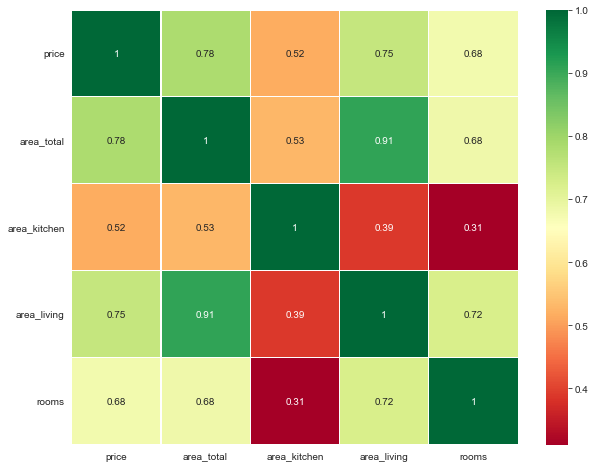

In [102]:
high_corr_df = df_num[high_corr_list]
sns.heatmap(high_corr_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

We see that there is pretty high correlations between all these features, which is not surprising. Should maybe combine them into a single feature.

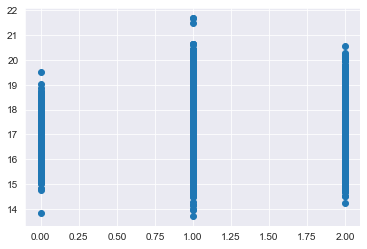

In [13]:
data_phone = data.loc[ ~data["phones"].isna()]
plt.scatter(data_phone["phones"], np.log(data_phone["price"]))


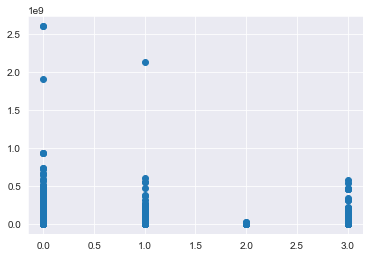

In [17]:
#plt.scatter(data["condition"], data["price"])
plt.scatter(data["heating"], data["price"])


# 'construction' feature 
There seems to be some nonlinear relationship with the response.

Imputation: Maybe use longitude and latitude to impute missung values for construction? A simple decision tree may be suited.

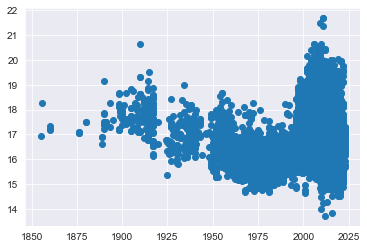

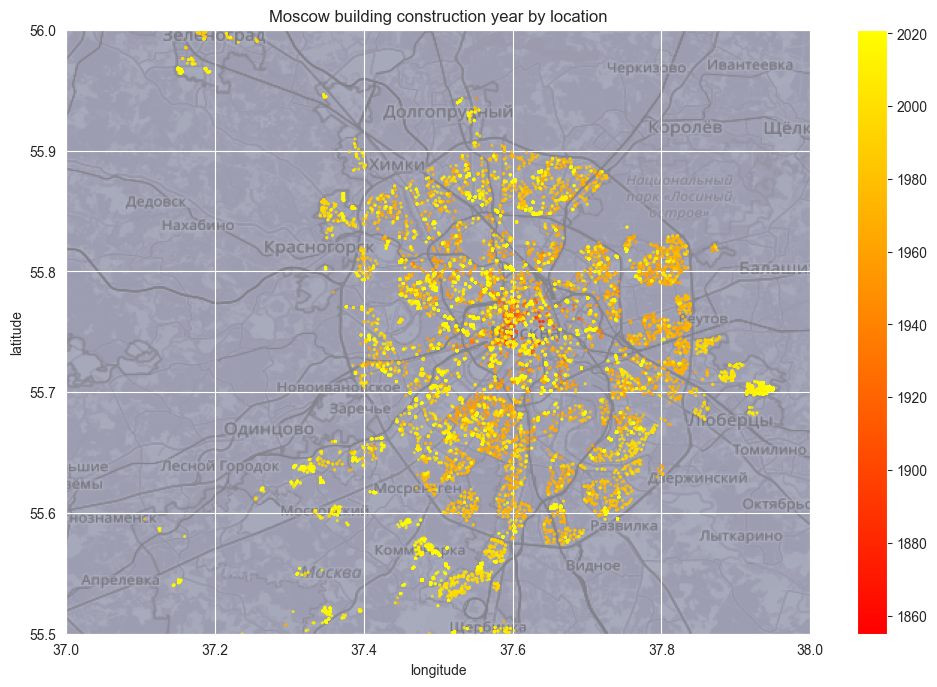

In [44]:
plt.scatter(data["constructed"], np.log(data["price"]))

def plot_map(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='autumn', column='constructed', title='Moscow building construction year by location'):
    data = data[['latitude', 'longitude', column]].dropna().sort_values(by=column, ascending=True)
    backdrop = plt.imread('resources/data/moscow.png')
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None 
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    ax.set_xlim(37, 38)    # min/max longitude of image 
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm

plot_map(data);

# XGBoost

In [40]:
import xgboost as xgb
import sklearn.model_selection as model_selection

def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5


data_train, data_valid = model_selection.train_test_split(data, test_size=0.33, stratify=np.log(data.price).round())
X_train = data_train[['latitude', 'longitude']]
y_train = data_train.loc[X_train.index].price
X_valid = data_valid[['latitude', 'longitude']]
y_valid = data_valid.loc[X_valid.index].price

dtrain = xgb.DMatrix(X_train, label = y_train)
dval = xgb.DMatrix(X_valid)
param = {'max_depth': 2, 'eta': 1e3, 'objective': 'reg:squaredlogerror'}
num_round = 10000

bst = xgb.train(param, dtrain, num_round)
preds_train = bst.predict(dtrain)
preds_valid = bst.predict(dval)
# Pretty darn shitty results                                
print(root_mean_squared_log_error(preds_train, y_train))
print(root_mean_squared_log_error(preds_valid, y_valid))




/Users/jimtotland/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/Users/jimtotland/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your c

9.215685467270928
9.22078866855869
